In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import torch


from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from src.word_to_embedding import WordToEmbedding

RANDOM_STATE = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
w2e = WordToEmbedding()

/home/lyubolp/detecting-loanwords/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/lyubolp/detecting-loanwords/src/transcription_dataset_single_word.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(row[0], str):
/home/lyubolp/detecting-loanwords/src/transcription_dataset_single_word.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataF

In [3]:
def generate_label_mapping(data: pd.DataFrame):
    label_to_id = {item: i for i, item in enumerate(set(data['произход']))}
    id_to_label = {index: label for label, index in label_to_id.items()}

    return label_to_id, id_to_label

In [4]:
class LoanwordsDataset(Dataset):
    def __init__(self, data: pd.DataFrame, label_to_id: dict[str, int], embeddeing_engine: WordToEmbedding):
        self.__data = data
        self.__len = self.__data.shape[0]
        
        self.__label_mapping = label_to_id
        self.__embeddeing_engine = embeddeing_engine


    def __len__(self):
        return self.__len

    def __getitem__(self, index) -> tuple[str, str]:
        entry = self.__data.iloc[index]

        word = entry['дума']
        origin = entry['произход']
        word_tensor = self.__embeddeing_engine.get_embedding(word)
        origin_tensor = self.__label_mapping[origin]

        word_tensor_shape = word_tensor.shape
        word_tensor = word_tensor.reshape((1, word_tensor_shape[0], word_tensor_shape[1]))

        return word, word_tensor, origin, origin_tensor


In [5]:
class LoanwordClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()

        self.__lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)
        self.__linear = nn.Linear(hidden_size, output_size).to(device)
        self.__softmax = nn.LogSoftmax(dim=1).to(device)

    
    def forward(self, x):
        h = self.__lstm(x)
        h = h[0]
        x = self.__linear(h)
        x = self.__softmax(x)

        return x

In [6]:
def category_from_output(output, id_to_label):
    top_n, top_i = output.topk(1)

    category_i = top_i[0].item()
    return id_to_label[category_i], category_i

In [26]:
def train_epoch(model: LoanwordClassifier, train_dataloader, loss_fn,  id_to_label, learning_rate=0.005):
    model.train()
    sum_loss = 0

    for _, word_tensor, _, label_tensor in tqdm(train_dataloader):
        word_tensor = word_tensor[0]  # Not working with batches, so far
        model.zero_grad()

        output = model(word_tensor)[:, -1, :]

        loss = loss_fn(output, label_tensor)
        
        loss.backward()

        sum_loss += loss.item()

    return sum_loss / len(train_dataloader)

In [8]:
# Train & Test loop
def train_loop(model: LoanwordClassifier, train_dataloader, epochs, loss_fn, id_to_label, learning_rate=0.005):
    for epoch in range(epochs):
        
        epoch_loss = train_epoch(model, train_dataloader, loss_fn, id_to_label, learning_rate)
        print(f"Epoch: {epoch}, loss: {epoch_loss:>7f}")

In [9]:
def test_loop(model: LoanwordClassifier, test_dataloader, id_to_label):
    predicted_ids = []
    actual_ids = []
    for word, word_tensor, label, label_tensor in tqdm(test_dataloader):
        word_tensor = word_tensor[0]

        hidden = model.init_hidden()

        for syllable_embedding in word_tensor:
            output, hidden = model(syllable_embedding, hidden)

        predicted_label, predicted_label_id = category_from_output(output, id_to_label)
        # print(predicted_label, predicted_label_id)
        predicted_ids.append(predicted_label_id)
        actual_ids.append(label_tensor)
    
    return predicted_ids, actual_ids

In [27]:
path = '/mnt/d/Projects/masters-thesis/data/loanwords.csv'
data = pd.read_csv(path)
label_to_id, id_to_label = generate_label_mapping(data)

# Running the model with normal labels 
train_data, test_data = train_test_split(data, random_state=RANDOM_STATE)


train_dataset = LoanwordsDataset(train_data, label_to_id, embeddeing_engine=w2e)
train_dataloader = DataLoader(train_dataset)

test_dataset = LoanwordsDataset(test_data, label_to_id, embeddeing_engine=w2e)
test_dataloader = DataLoader(test_dataset)

model = LoanwordClassifier(input_size=512, hidden_size=2048, output_size=len(label_to_id))

In [28]:
train_loop(model, train_dataloader, epochs=1, loss_fn=nn.CrossEntropyLoss(), id_to_label=id_to_label)

  1%|          | 168/31501 [00:37<1:57:26,  4.45it/s]


KeyboardInterrupt: 

In [11]:
from datetime import datetime
today_date = datetime.today().strftime('%Y-%m-%d')
torch.save(model.state_dict(), f'models/lstm_classifier-{today_date}-1024hidden-10epochs.pth')

In [19]:
p, a = test_loop(model, test_dataloader, id_to_label)
a = [t.item() for t in a]

100%|██████████| 10501/10501 [00:34<00:00, 308.45it/s]


In [57]:
results = list(zip(p, a))
correct = sum(1 for p, a in results if p == a)


f'correct: {correct}, accuracy: {correct / len(results) * 100:.2f}%, f1: {f1_score(a, p, average="weighted"):.3f}'

'correct: 7541, accuracy: 71.81%, f1: 0.688'

/tmp/ipykernel_966/575425773.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
/tmp/ipykernel_966/575425773.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + list(label_to_id.keys()))


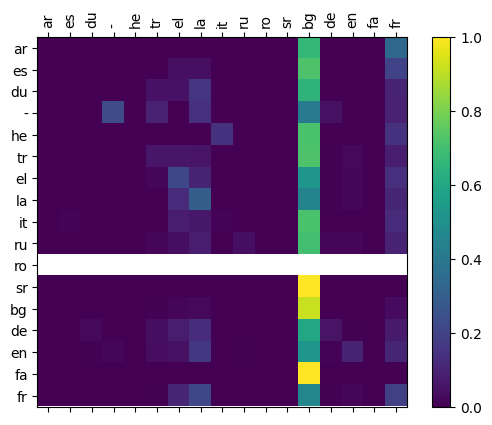

In [43]:
confusion = torch.zeros(len(label_to_id), len(label_to_id))
for predicted, actual in results:
    confusion[actual][predicted] += 1

for i in range(len(label_to_id)):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(label_to_id.keys()), rotation=90)
ax.set_yticklabels([''] + list(label_to_id.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()